In [1]:
from keras import layers, models

Using TensorFlow backend.


### 모델링
- 마지막 부분이, 분류 때와 다르게 FC layer가 아닌 것에 주목
- FC layer가 아닌 Conv layer
- filter의 size만 명시하면되고 depth는 알아서 계산해주는듯 하다.

#### CNN 참고자료
- https://tykimos.github.io/2017/01/27/CNN_Layer_Talk/

In [2]:
def Conv2D(filters, kernel_size, padding='same', activation='relu'):
    return layers.Conv2D(filters, kernel_size, padding=padding, activation=activation)

In [3]:
class AE(models.Model):
    def __init__(self, org_shape=(1, 28, 28)):
        # Input
        original = layers.Input(shape=org_shape) # keras 설정에 따라 (28, 28, 1), (1, 28, 28)
        
        # encoding-1
        x = Conv2D(4, (3, 3))(original) # 36 weights + 4 bias
        x = layers.MaxPooling2D((2, 2), padding='same')(x) # 크기는 4분의 1로 줄어듬, 개수는 4배
        
        # encoding-2
        x = Conv2D(8, (3, 3))(x)
        x = layers.MaxPooling2D((2, 2), padding='same')(x) 
        
        # encoding-3: encoding output: 7x7 pixels -> 28x28 였던 이미지가 7x7 크기로 부호화 됨
        z = Conv2D(1, (7, 7))(x)
        
        # decoding-1 -> 필터 수를 늘려서 전체 이미지 공간(?)을 늘림
        y = Conv2D(16, (3, 3))(z)
        y = layers.UpSampling2D((2, 2))(y) # 14 x 14 이미지로 변환
        
        # decoding-2 -> 16장의 이미지를 8장으로 줄이면서 화소를 더 정교화
        y = Conv2D(8, (3, 3))(y) 
        y = layers.UpSampling2D((2, 2))(y) # 28 x 28 이미지로 변환
        
        # decoding-3 -> Conv를 한번 더 적용 (이미지 특징점들을 더 구체적으로 묘사), 매 단계마다 피쳐들간의 조합들이 일어날 것임 
        y = Conv2D(4, (3, 3))(y) 
        
        # Output / 흑백 이미지의 성격을 반영향 sigmoid
        decoded = Conv2D(1, (3, 3), activation='sigmoid')(y)
        
        super().__init__(original, decoded)
        self.compile(optimizer='adadelta', loss='binary_crossentropy', metrics=['accuracy'])
        self.summary()


### 데이터 준비 및 학습 효과 분석

In [4]:
# CNN 예제 소스 중 DATA 부분 가져옴
import keras
from keras import datasets

class DATA():
    def __init__(self):
        num_classes = 10

        (x_train, y_train), (x_test, y_test) = datasets.mnist.load_data()
        img_rows, img_cols = x_train.shape[1:]

        if backend.image_data_format() == 'channels_first':
            x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
            x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
            input_shape = (1, img_rows, img_cols)
        else:
            x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
            x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
            input_shape = (img_rows,img_cols, 1)

        x_train = x_train.astype('float32')
        x_test = x_test.astype('float32')
        x_train /= 255
        x_test /= 255

        y_train = keras.utils.to_categorical(y_train, num_classes)
        y_test = keras.utils.to_categorical(y_test, num_classes)

        self.input_shape = input_shape
        self.num_classes = num_classes
        self.x_train, self.y_train = x_train, y_train
        self.x_test, self.y_test = x_test, y_test

In [5]:
from keraspp.skeras import plot_loss, plot_acc
import matplotlib.pyplot as plt

### 합성곱 AE 결과 시각화

In [6]:
from keras import backend

def show_ae(autoencoder, data):
    x_test = data.x_test
    decoded_imgs = autoencoder.predict(x_test)
    print(decoded_imgs.shape, data.x_test.shape)
    
    if backend.image_data_format() == 'channels_first':
        N, n_ch, n_i, n_j = x_test.shape
    else:
        N, n_i, n_j, n_ch = x_test.shape
    
    x_test = x_test.reshape(N, n_i, n_j)
    decoded_imgs = decoded_imgs.reshape(decoded_imgs.shape[0], n_i, n_j)
    
    n = 10
    plt.figure(figsize=(20,4))
    for i in range(n):
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(x_test[i])
        # plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(decoded_imgs[i])
        # plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
    plt.show()

### 합성곱 AE 학습 및 성능 평가

In [7]:
def main(epochs=20, batch_size=128):
    data = DATA()
    autoencoder = AE(data.input_shape)
    
    history = autoencoder.fit(data.x_train, data.x_train,
                         epochs=epochs,
                         batch_size=batch_size,
                         shuffle=True,
                         validation_split=0.2)
    
    plot_acc(history)
    plt.show()
    plot_loss(history)
    plt.show()
    
    show_ae(autoencoder, data)
    plt.show()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 4)         40        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 4)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 8)         296       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 8)           0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 1)           393       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 7, 7, 16)          160       
__________

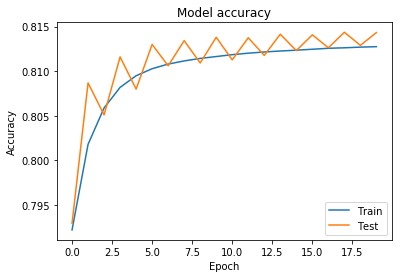

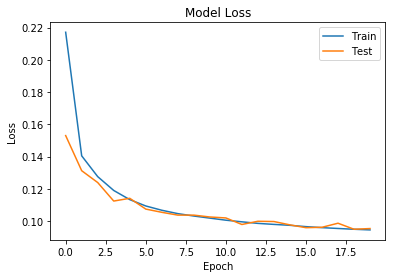

(10000, 28, 28, 1) (10000, 28, 28, 1)


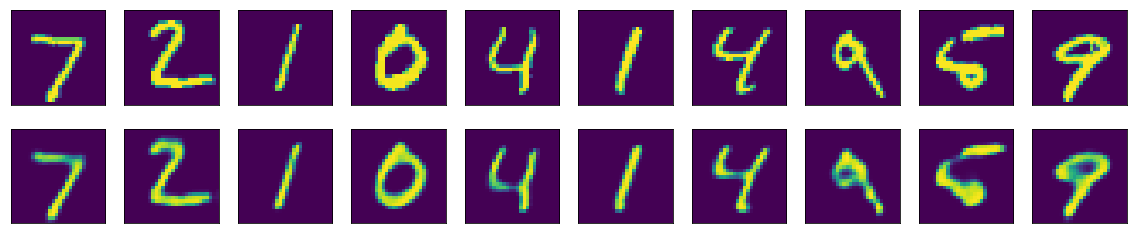

In [8]:
main()